<h2>Question 35: Precision and Recall</h2>

<h3>Precision</h3>
<p>The fraction of the items that from the returned item set (predicted items, recommended items from the model) that are real relavent items (items that are true positivie) among the total returned item set (all predicted or recommended items from the model).</p>
<h3>Recall</h3>
<p>The fraction of the items that from the returned item set (predicted itesm, recommended items from the model) that are reall relavent items (items that are true positivie) among the total relavent item set (all true positive items from the data).</p>

In [1]:
%run Common.ipynb

import os.path
import pandas as pd

#!pip install surprise
from surprise import Dataset, Reader
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import SVD, NMF
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import train_test_split
from collections import defaultdict

np.set_printoptions(suppress=True,floatmode='maxprec_equal')

In [2]:
#get precision and recall function, threshold = 3

def precision_recall_at_t(predictions, t=10, threshold=3.5):
    '''Return precision and recall at t metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top t
        n_rec_t = sum((est >= threshold) for (est, _) in user_ratings[:t])

        # Number of relevant and recommended items in top t
        n_rel_and_rec_t = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:t])

        # Precision@T: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_t / n_rec_t if n_rec_t != 0 else 1

        # Recall@T: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_t / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [3]:
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_file('ml-latest-small/ratings.csv', reader=reader)

In [4]:
t_list = np.linspace(1,25,25).astype(int)
t_list

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25])

In [5]:
trainset = data.build_full_trainset()
testset = trainset.build_testset()

<h2>Question 36: k-NN</h2>

In [6]:
#Question 11
k_q11 = 18

sim_options = {'name': 'pearson',
               'user_based': True  # compute similarities between users
               }
knn = KNNWithMeans(k=k_q11, sim_options=sim_options)
knn.fit(trainset)
predictions = knn.test(testset)

cols=['t','Avg Precision (KNN)', 'Avg Recall']
df_knn_measures = pd.DataFrame(columns=cols)

for t in log_progress(t_list):
    precisions, recalls = precision_recall_at_t(predictions, t=t)
    df_knn_measures = df_knn_measures.append({cols[0]:t,
                                          cols[1]:sum(precisions.values()) / len(precisions),
                                          cols[2]:sum(recalls.values()) / len(recalls)},
                                         ignore_index=True)

df_knn_measures.set_index('t', inplace=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [7]:
df_knn_measures

Avg Precision (KNN)  Avg Recall
t                                    
1.0              1.000000    0.031609
2.0              0.999255    0.061808
3.0              0.999255    0.090537
4.0              0.999255    0.118521
5.0              0.998957    0.145471
6.0              0.999006    0.171675
7.0              0.998403    0.196658
8.0              0.997738    0.220369
9.0              0.996724    0.242880
10.0             0.995995    0.264345
11.0             0.995060    0.284597
12.0             0.993863    0.303884
13.0             0.992774    0.322208
14.0             0.992013    0.340020
15.0             0.990374    0.356126
16.0             0.989088    0.371383
17.0             0.987483    0.385846
18.0             0.985501    0.398933
19.0             0.984237    0.412084
20.0             0.982131    0.423965
21.0             0.981080    0.435888
22.0             0.979755    0.447135
23.0             0.978205    0.457717
24.0             0.977023    0.467922
25.0             0.975371    0.477423

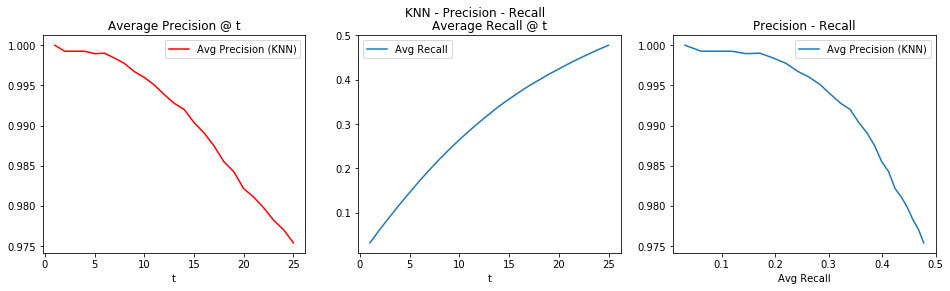

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(16)
fig.set_figheight(4)
fig.suptitle("KNN - Precision - Recall")
df_knn_measures[[r'Avg Precision (KNN)']].plot(ax=axes[0], title="Average Precision @ t", xticks=np.linspace(0,25,6), color='red')
df_knn_measures[['Avg Recall']].plot(ax=axes[1], title="Average Recall @ t", xticks=np.linspace(0,25,6))
_ = df_knn_measures.plot(y='Avg Precision (KNN)', x='Avg Recall', ax=axes[2], title="Precision - Recall")

<h2>Question 37: NMF</h2>

In [9]:
#Question 11
k_q18 = 20

nmf = NMF(n_factors=k_q18)
nmf.fit(trainset)
predictions = nmf.test(testset)

cols=['t','Avg Precision (NMF)', 'Avg Recall']
df_nmf_measures = pd.DataFrame(columns=cols)

for t in log_progress(t_list):
    precisions, recalls = precision_recall_at_t(predictions, t=t)
    df_nmf_measures = df_nmf_measures.append({cols[0]:t,
                                          cols[1]:sum(precisions.values()) / len(precisions),
                                          cols[2]:sum(recalls.values()) / len(recalls)},
                                         ignore_index=True)

df_nmf_measures.set_index('t', inplace=True)

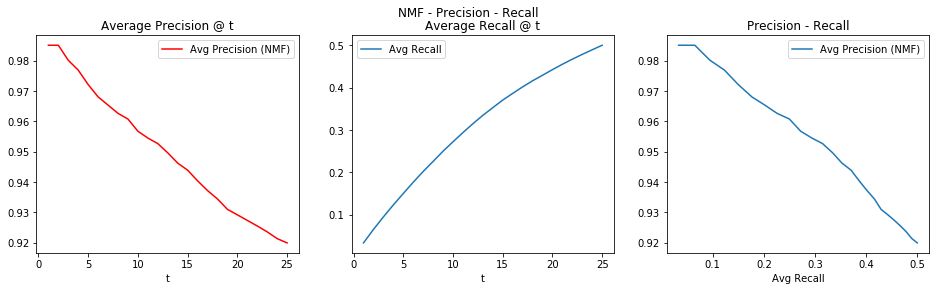

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(16)
fig.set_figheight(4)
fig.suptitle("NMF - Precision - Recall")
df_nmf_measures[['Avg Precision (NMF)']].plot(ax=axes[0], title="Average Precision @ t", xticks=np.linspace(0,25,6), color='red')
df_nmf_measures[['Avg Recall']].plot(ax=axes[1], title="Average Recall @ t", xticks=np.linspace(0,25,6))
_ = df_nmf_measures.plot(y='Avg Precision (NMF)', x='Avg Recall', ax=axes[2], title="Precision - Recall")

<h2>Question 38: MF w/ Bias</h2>

In [11]:
#Question 11
k_q18 = 20

svd = SVD(n_factors=k_q18)
svd.fit(trainset)
predictions = svd.test(testset)

cols=['t','Avg Precision (MF w/ Bias)', 'Avg Recall']
df_svd_measures = pd.DataFrame(columns=cols)

for t in log_progress(t_list):
    precisions, recalls = precision_recall_at_t(predictions, t=t)
    df_svd_measures = df_svd_measures.append({cols[0]:t,
                                          cols[1]:sum(precisions.values()) / len(precisions),
                                          cols[2]:sum(recalls.values()) / len(recalls)},
                                         ignore_index=True)

df_svd_measures.set_index('t', inplace=True)

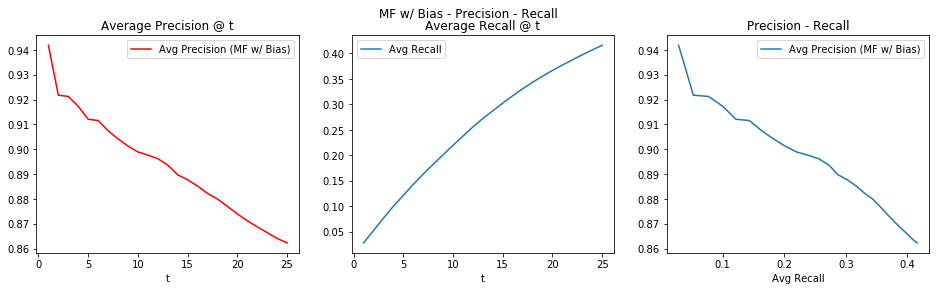

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(16)
fig.set_figheight(4)
fig.suptitle("MF w/ Bias - Precision - Recall")
df_svd_measures[['Avg Precision (MF w/ Bias)']].plot(ax=axes[0], title="Average Precision @ t", xticks=np.linspace(0,25,6), color='red')
df_svd_measures[['Avg Recall']].plot(ax=axes[1], title="Average Recall @ t", xticks=np.linspace(0,25,6))
_ = df_svd_measures.plot(y='Avg Precision (MF w/ Bias)', x='Avg Recall', ax=axes[2], title="Precision - Recall")

<h1>Question 39</h1>

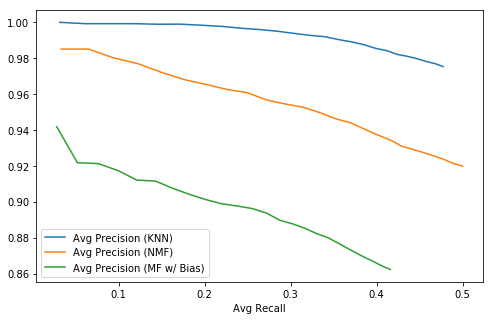

In [13]:
#plt.subplots(nrows=1, ncols=1)
#fig.suptitle("SVD - Precision - Recall")
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(5)
df_knn_measures.plot(y='Avg Precision (KNN)', x='Avg Recall', ax=ax)
df_nmf_measures.plot(y='Avg Precision (NMF)', x='Avg Recall', ax=ax)
_ = df_svd_measures.plot(y='Avg Precision (MF w/ Bias)', x='Avg Recall', ax=ax)

<p>The best performing filter is the KNN collaborative filter. Precision of KNN filter barely drop at higher recall. The MF with bias collaborative filter performed the worst.</p>